In [225]:
from collections import deque
from talib import SMA
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

Get the prices of for our assets

In [203]:
tickers = ['AAPL','MSFT','IBM','ABT','CSCO']
p = get_pricing(tickers,'2005-01-01','2017-01-05')


In [204]:
p['price'].index

DatetimeIndex(['2005-01-03', '2005-01-04', '2005-01-05', '2005-01-06',
               '2005-01-07', '2005-01-10', '2005-01-11', '2005-01-12',
               '2005-01-13', '2005-01-14',
               ...
               '2016-12-21', '2016-12-22', '2016-12-23', '2016-12-27',
               '2016-12-28', '2016-12-29', '2016-12-30', '2017-01-03',
               '2017-01-04', '2017-01-05'],
              dtype='datetime64[ns, UTC]', length=3024, freq='C')

#Implement Strategy

In [212]:
def get_result(col,a,b,p):
    idx = p['price'].columns[col]

    price = p.minor_xs(idx)['price']
    smaA = price.rolling(a).mean()
    smaB = price.rolling(b).mean()
    sma_diff = smaA-smaB
    signal = np.sign(sma_diff).diff()/2
    pnl = (((price*signal).cumsum())-(price*signal.cumsum()))
    return pnl


In [213]:
plot_result(0,10,20).ix[-1]

32.578000000000003

#Run Strategy for portfolio

In [215]:
def portfolio(a,b,tickers,p):
    portfolio_pnl = 0
    for i in range(len(tickers)):
        portfolio_pnl += get_result(i,a,b,p).ix[-1]
    return portfolio_pnl

portfolio(20,10,tickers,p)

34.149999999999899

#Optimise Strategy parameters

(array([    7.,     9.,     4.,     6.,     5.,     3.,    10.,    18.,
           24.,    94.,   114.,   177.,   513.,   618.,   731.,   813.,
         1084.,  1196.,  1054.,   890.,   658.,   321.,   183.,   145.,
          205.,   209.,   379.,   256.,   222.,    52.]),
 array([-135.973 , -125.4959, -115.0188, -104.5417,  -94.0646,  -83.5875,
         -73.1104,  -62.6333,  -52.1562,  -41.6791,  -31.202 ,  -20.7249,
         -10.2478,    0.2293,   10.7064,   21.1835,   31.6606,   42.1377,
          52.6148,   63.0919,   73.569 ,   84.0461,   94.5232,  105.0003,
         115.4774,  125.9545,  136.4316,  146.9087,  157.3858,  167.8629,
         178.34  ]),
 <a list of 30 Patch objects>)

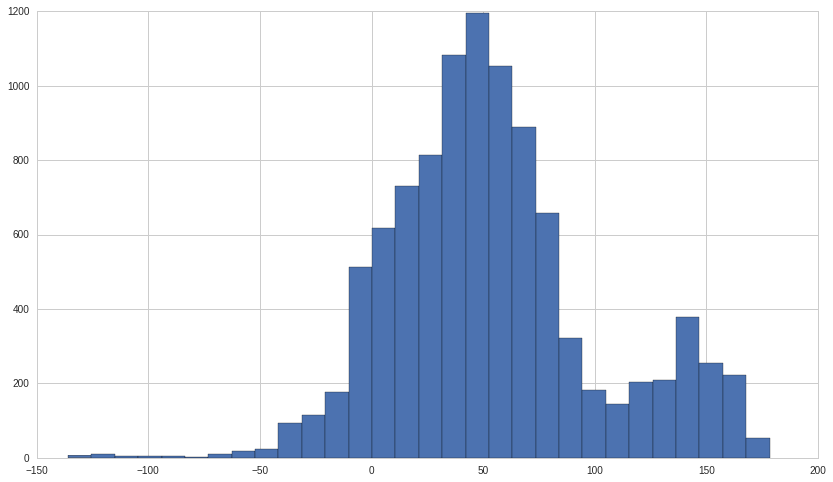

In [219]:
def optimise(tickers,p):
    pnls = []
    
    for a in range(1000):
        params = np.sort([np.random.randint(5,100),np.random.randint(5,100)])[::-1]
        pnls.append(portfolio(params[0],params[1],tickers,p))
    return pnls
            
pnls = optimise(tickers,p)
plt.hist(pnls,30)

In [220]:
np.mean(pnls)

54.195401099999984

In [221]:
np.std(pnls)

46.65590227438345

#PnL of equally weighted portfolio

In [267]:
def portfolio(a,b,tickers,p):
    portfolio_pnls = []
    for i in range(len(tickers)):
        portfolio_pnls.append(get_result(i,a,b,p))
    df = pd.DataFrame(portfolio_pnls).T
    #df.plot()
    return df

df = portfolio(110,50,tickers,p)

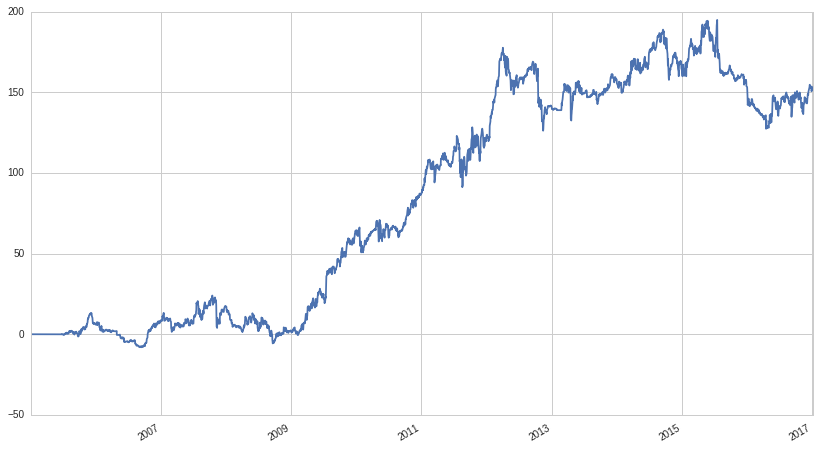

In [268]:
df.sum(axis=1).plot()